In [6]:
#%pip install transformers
# %conda create -n pytorch python=3.7
# %conda activate pytorch
# %conda install pytorch
#%pip install torch torchvision torchaudio
#%pip install scipy
# %pip install datasets -qq
# %pip install evaluate -qq
# %pip install albumentations -qq
# %pip install git+https://github.com/huggingface/transformers.git -qq
# %pip install huggingface_hub -qq


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [32]:

import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    MaskFormerConfig,
    MaskFormerImageProcessor,
    MaskFormerModel,
    MaskFormerForInstanceSegmentation,
)
import evaluate
from huggingface_hub import notebook_login

In [33]:
# Load Scene Parsing dataset’s instance segmentation data
dataset = load_dataset("segments/sidewalk-semantic")
dataset = dataset.shuffle(seed=1)
dataset = dataset["train"].train_test_split(test_size=0.2)
train = dataset["train"]
test = dataset["test"]

Found cached dataset parquet (/Users/christopherhoward/.cache/huggingface/datasets/segments___parquet/segments--sidewalk-semantic-2-1680095ec7b2b03f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 19.79it/s]
Loading cached shuffled indices for dataset at /Users/christopherhoward/.cache/huggingface/datasets/segments___parquet/segments--sidewalk-semantic-2-1680095ec7b2b03f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-dc5e003bf815860f.arrow


## Displaying a random image and its annotation from the training dataset

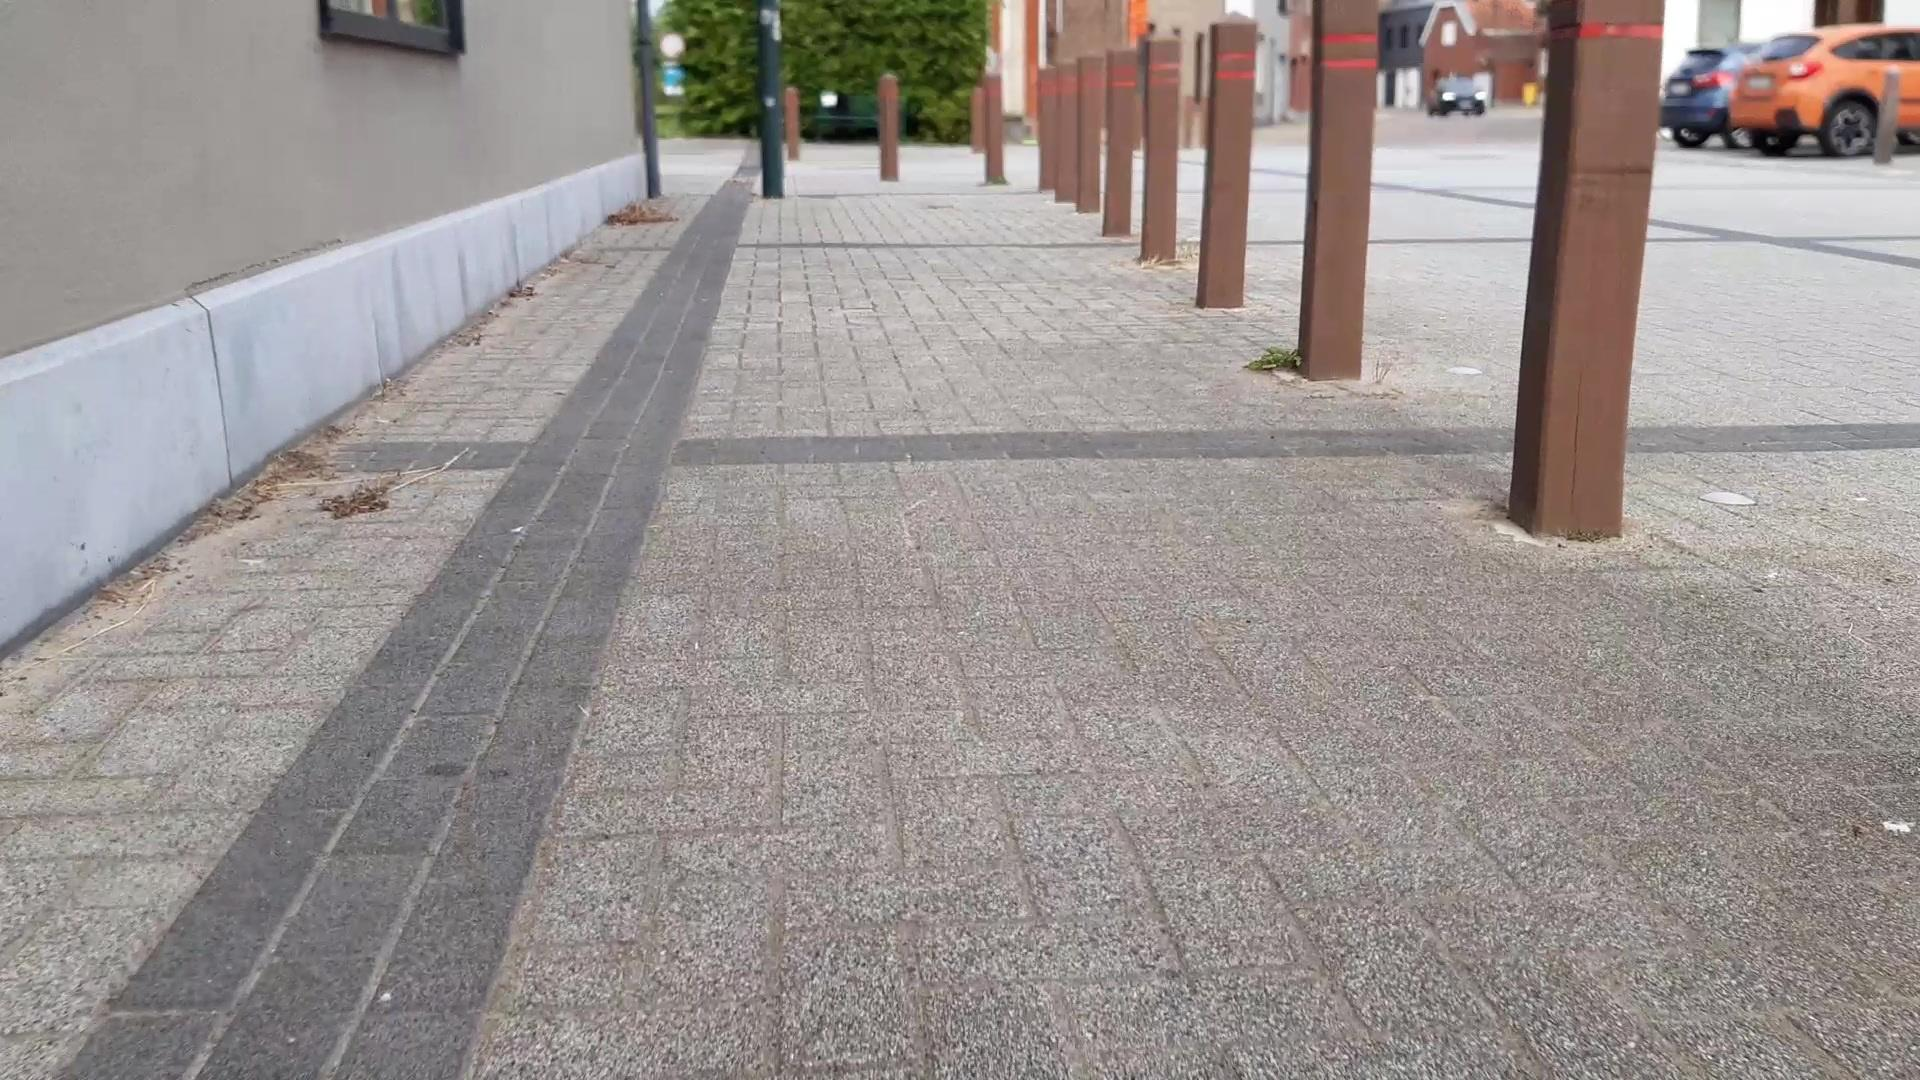

In [34]:
# Displaying a random image and its annotation
index = random.randint(0, len(train))
example = train[index]
image = example["pixel_values"]
image

# image = np.array(image.convert("RGB"))
# annotation = train[index]["annotation"]
# annotation = np.array(annotation)

# plt.figure(figsize=(15, 5))
# for plot_index in range(3):
#     if plot_index == 0:
#         # If plot index is 0 display the original image
#         plot_image = image
#         title = "Original"
#     else:
#         # Else plot the annotation maps
#         plot_image = annotation[..., plot_index - 1]
#         title = ["Class Map (R)", "Instance Map (G)"][plot_index - 1]
#     # Plot the image
#     plt.subplot(1, 3, plot_index + 1)
#     plt.imshow(plot_image)
#     plt.title(title)
#     plt.axis("off")


### Instance annotation masks are stored in RGB image format in SP dataset, we want green (g) channel which encodes instance ID.

In [35]:
#
from transformers import MaskFormerImageProcessor
# Use default configuration
preprocessor = MaskFormerImageProcessor(ignore_index=0, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)


/Users/christopherhoward/Library/r-miniconda/lib/python3.9/site-packages/transformers/models/maskformer/image_processing_maskformer.py:421: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [36]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]
    
    return batch

train_dataloader = DataLoader(train, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test, batch_size=2, shuffle=False, collate_fn=collate_fn)
     

In [37]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['pixel_values'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])
        
        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

In [38]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    A.LongestMaxSize(max_size=1333),
    A.RandomCrop(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

test_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),

])

train_dataset = ImageSegmentationDataset(train, transform=train_transform)
test_dataset = ImageSegmentationDataset(test, transform=test_transform)

In [39]:
import torch

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

ValueError: Invalid image type. Must be of type PIL.Image.Image, numpy.ndarray, torch.Tensor, tf.Tensor or jax.ndarray.

In [4]:

# url = "https://huggingface.co/datasets/hf-internal-testing/fixtures_ade20k/resolve/main/ADE_val_00000001.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

# processor = MaskFormerImageProcessor.from_pretrained("facebook/maskformer-swin-large-ade")
# inputs = processor(images=image, return_tensors="pt")

# model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-large-ade")
# outputs = model(**inputs)
# # model predicts class_queries_logits of shape `(batch_size, num_queries)`
# # and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
# class_queries_logits = outputs.class_queries_logits
# masks_queries_logits = outputs.masks_queries_logits

# # you can pass them to processor for postprocessing
# # we refer to the demo notebooks for visualization (see "Resources" section in the MaskFormer docs)
# predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

/Users/christopherhoward/Library/r-miniconda/lib/python3.9/site-packages/transformers/models/maskformer/image_processing_maskformer.py:403: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
/Users/christopherhoward/Library/r-miniconda/lib/python3.9/site-packages/transformers/models/maskformer/image_processing_maskformer.py:410: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(


In [ ]:
#config = 